In [1]:
from dichasus_cf0x import training_set, spec
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm.auto import tqdm

2024-02-10 16:03:05.442858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 16:03:06.171257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-10 16:03:07.199370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:03:07.223089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

### Data normalization:
* Normalize delay spreads to range -1 to 1
* Normalize both position coordinates to range -1 to 1

In [2]:
delayspreads = np.load("results/training_set_delayspreads.npy")
delayspreads_min = np.min(delayspreads)
delayspreads_max = np.max(delayspreads)

In [3]:
def normalize_ds(ds):
    return 2 * (ds - delayspreads_min) / (delayspreads_max - delayspreads_min) - 1

In [4]:
positions = np.load("results/training_set_positions.npy")
pos_xmin = np.min(positions[:,0])
pos_xmax = np.max(positions[:,0])
pos_ymin = np.min(positions[:,1])
pos_ymax = np.max(positions[:,1])

def normalize_pos(pos):
    x_norm = 2 * (pos[...,0] - pos_xmin) / (pos_xmax - pos_xmin) - 1
    y_norm = 2 * (pos[...,1] - pos_ymin) / (pos_ymax - pos_ymin) - 1
    return tf.stack([x_norm, y_norm], axis = -1)

### Parameter Definitions

In [5]:
ANTENNACOUNT_ARRAYS = None
ANTENNACOUNT_ROWS = None
ANTENNACOUNT_COLUMNS = None
TAPS = None

for csi, pos, time, ds in training_set.take(1):
    csishape = tf.shape(csi).numpy()
    ANTENNACOUNT_ARRAYS = csishape[0]
    ANTENNACOUNT_ROWS = csishape[1]
    ANTENNACOUNT_COLUMNS = csishape[2]
    TAPS = csishape[3]

ANTENNACOUNT_TOTAL = ANTENNACOUNT_ARRAYS * ANTENNACOUNT_ROWS * ANTENNACOUNT_COLUMNS

In [6]:
DISCRIMINATOR_TRAININGS_PER_GENERATOR_TRAINING = 10
EPOCHS = 500
BATCH_SIZE = 512
NOISE_SHAPE = 128

initial_learning_rate = 1e-4
lr_schedule_G = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

lr_schedule_D = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.93, #0.94 bei 25 D iterations
    staircase=True)

G_optimizer = tf.keras.optimizers.Adam(lr_schedule_G)
D_optimizer = tf.keras.optimizers.Adam(lr_schedule_D)

### Model Definition

In [7]:
def make_generator_model():
    inp_noise = tf.keras.layers.Input(shape = (NOISE_SHAPE,))
    inp_poslabel = tf.keras.layers.Input(shape = (2,))
    
    data = tf.keras.layers.Concatenate()([inp_noise, inp_poslabel])
    data = tf.keras.layers.Dense(2**9, activation = "relu")(data)
    data = tf.keras.layers.Dense(2**9, activation = "relu")(data)
    data = tf.keras.layers.Dense(2**10, activation = "relu")(data)
    data = tf.keras.layers.Dense(2**11, activation = "relu")(data)
    data = tf.keras.layers.Dense(ANTENNACOUNT_TOTAL * 2 * TAPS, activation = "linear")(data)
    data = tf.keras.layers.Reshape((ANTENNACOUNT_ARRAYS, ANTENNACOUNT_ROWS, ANTENNACOUNT_COLUMNS, TAPS, 2))(data)
    
    model = tf.keras.Model([inp_noise, inp_poslabel], data)
    
    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 130)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 512)                  67072     ['concatenate[0][0]']     

In [9]:
def make_discriminator_model():
    inp_poslabel = tf.keras.layers.Input(shape=(2,))
    inp_csi = tf.keras.layers.Input(shape=(ANTENNACOUNT_ARRAYS, ANTENNACOUNT_ROWS, ANTENNACOUNT_COLUMNS, TAPS, 2))
    ds_calc = tf.keras.layers.Input(shape=(ANTENNACOUNT_ARRAYS, ANTENNACOUNT_ROWS, ANTENNACOUNT_COLUMNS))
    
    x = tf.keras.layers.Dense(160, activation = "relu")(tf.keras.layers.Flatten()(inp_csi))
    x = tf.keras.layers.Dense(100, activation = "relu")(x)
    x = tf.keras.layers.Dense(50, activation = "relu")(x)
    x = tf.keras.layers.Concatenate()([x, inp_poslabel, tf.keras.layers.Flatten()(ds_calc)])
    x = tf.keras.layers.Dense(20, activation = "relu")(x)
    x = tf.keras.layers.Dense(10, activation = "relu")(x)
    x = tf.keras.layers.Dense(1, activation = "linear")(x)

    model = tf.keras.Model(inputs = [inp_csi, inp_poslabel, ds_calc], outputs = [x])
    
    return model

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 4, 2, 4, 48, 2)]     0         []                            
                                                                                                  
 flatten (Flatten)           (None, 3072)                 0         ['input_4[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 160)                  491680    ['flatten[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 100)                  16100     ['dense_5[0][0]']             
                                                                                            

In [11]:
# Dummy dry-run
generated_csi = generator([tf.random.normal([1, NOISE_SHAPE]), tf.zeros((1, 2))], training = False)
decision = discriminator([generated_csi, tf.zeros((1, 2)), tf.ones([1, ANTENNACOUNT_ARRAYS, ANTENNACOUNT_ROWS, ANTENNACOUNT_COLUMNS])], training = False)
print (decision)

tf.Tensor([[0.6661972]], shape=(1, 1), dtype=float32)


2024-02-10 16:03:10.050439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
def gradient_penalty(critic, real_csi, fake_csi, poslabel, real_ds, fake_ds):
    lamb = 10
    batchlen = tf.shape(poslabel)[0]
    alpha = tf.random.uniform([batchlen], minval = 0, maxval = 1, dtype = tf.dtypes.float32)
    
    real_csi = tf.cast(real_csi, tf.float32)
    interpolated = tf.einsum("d,darmtc->darmtc", alpha, real_csi) + tf.einsum("d,darmtc->darmtc", 1 - alpha, fake_csi)
    
    real_ds = tf.cast(real_ds, tf.float32)
    interpolated_ds = tf.einsum("d,darm->darm", alpha, real_ds) + tf.einsum("d,darm->darm", 1 - alpha, fake_ds)
    
    with tf.GradientTape() as gp_tape:
            gp_tape.watch([interpolated, poslabel, interpolated_ds])
            pred = critic([interpolated, poslabel, interpolated_ds], training = True)

    grads = gp_tape.gradient(pred, [interpolated, poslabel, interpolated_ds])

    # We explicitely do not want to penalize high gradients w.r.t. to the condition (poslabel)
    grads_all = tf.concat([
        tf.reshape(grads[0], [batchlen, -1]),
        tf.reshape(grads[2], [batchlen, -1])
    ], axis = 1)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads_all), axis = 1))
    gp = lamb * tf.reduce_mean((norm - 1.0) ** 2)

    return gp

In [13]:
def compute_delayspread(csi):
    powers = tf.square(csi[...,0]) + tf.square(csi[...,1])
    timestamps = tf.range(tf.shape(csi)[4], dtype = np.float32) / spec["bandwidth"]
    time_weighted_powers = tf.einsum("darmt,t->darmt", powers, timestamps)
    mean_delays = tf.divide(tf.reduce_sum(time_weighted_powers, axis = 4), tf.reduce_sum(powers, axis = 4))
    squared_delays = tf.square(timestamps[tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis, :] - mean_delays[..., tf.newaxis])
    delayspreads = tf.sqrt(tf.divide(tf.reduce_sum(tf.multiply(squared_delays, powers), axis = 4), tf.reduce_sum(powers, axis = 4)))

    return delayspreads

In [14]:
@tf.function
def WGAN_train_d_step(real_csi, poslabel, ds_label): #, batch_size, step):
    noise = tf.random.normal([tf.shape(poslabel)[0], NOISE_SHAPE], dtype=tf.dtypes.float32)

    with tf.GradientTape() as d_tape:
        fake_csi = generator([noise, poslabel], training = False)
        ds_fake = normalize_ds(compute_delayspread(fake_csi))
        fake_pred = discriminator([fake_csi, poslabel, ds_fake], training = True)
        real_pred = discriminator([real_csi, poslabel, ds_label], training = True)

        gp = gradient_penalty(discriminator, real_csi, fake_csi, poslabel, ds_label, ds_fake)

        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + gp

    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    
    return D_loss, gp, D_gradients[0]

@tf.function
def WGAN_train_g_step(poslabel):
    noise = tf.random.normal([tf.shape(poslabel)[0], NOISE_SHAPE], dtype=tf.dtypes.float32)

    with tf.GradientTape() as g_tape:
        fake_csi = generator([noise, poslabel], training = True)
        ds_fake = normalize_ds(compute_delayspread(fake_csi))
        fake_pred = discriminator([fake_csi, poslabel, ds_fake], training = False)

        G_loss = -tf.reduce_mean(fake_pred)

    G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    
    return G_loss, G_gradients[0], ds_fake

In [15]:
training_set = training_set.cache()

In [16]:
csi_all = []
pos_all = []
ds_all = []

for csi, pos, time, ds in training_set.batch(1000):
    csi_all.append(csi.numpy())
    pos_all.append(pos.numpy()[:,:2])
    ds_all.append(ds.numpy())

csi_all = np.concatenate(csi_all)
pos_all = np.concatenate(pos_all)
ds_all = np.concatenate(ds_all)

In [17]:
print(np.shape(csi_all))
print(np.shape(pos_all))
print(np.shape(ds_all))

(17857, 4, 2, 4, 48)
(17857, 2)
(17857, 4, 2, 4)


In [18]:
csi_real_imag = np.stack([np.real(csi_all), np.imag(csi_all)], axis = -1)
csi_gpu = tf.constant(csi_real_imag)
pos_gpu = tf.constant(tf.cast(normalize_pos(pos_all), tf.float32), dtype = tf.float32)
ds_gpu = tf.constant(normalize_ds(ds_all))

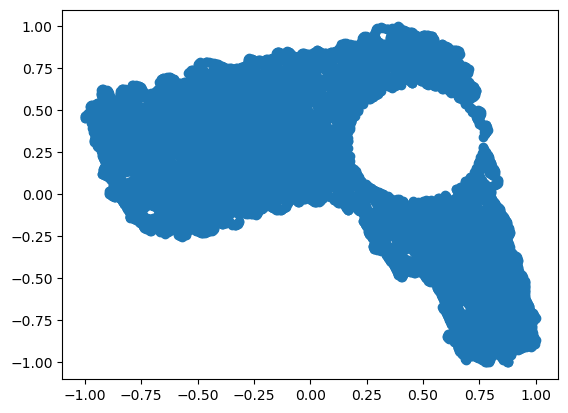

In [19]:
plt.scatter(pos_gpu[:,0], pos_gpu[:,1])
plt.show()

In [20]:
loss_G = []
loss_D = []

for epoch in tqdm(range(EPOCHS)):
    shuffled_indices = np.arange(tf.shape(csi_all)[0])
    np.random.shuffle(shuffled_indices)

    for offset in range(0, len(shuffled_indices), BATCH_SIZE):
        batch_indices = shuffled_indices[offset:offset + BATCH_SIZE]
        csi_batch = tf.gather(csi_gpu, batch_indices)
        poslabels = tf.gather(pos_gpu, batch_indices)
        ds_label = tf.gather(ds_gpu, batch_indices)

        for i in range(DISCRIMINATOR_TRAININGS_PER_GENERATOR_TRAINING):
            D_loss, gp, D_gradients = WGAN_train_d_step(csi_batch, poslabels, ds_label)

        G_loss, G_gradients, ds_fake2 = WGAN_train_g_step(poslabels)

    loss_G.append(G_loss)
    loss_D.append(D_loss)
    tqdm.write("G loss: " + str(G_loss.numpy()))
    tqdm.write("D loss: " + str(D_loss.numpy()))
    tqdm.write("GP    : " + str(gp.numpy()))
    #tqdm.write("G grad: " + str(tf.reduce_mean(tf.abs(G_gradients)).numpy()))
    #tqdm.write("D grad: " + str(tf.reduce_mean(tf.abs(D_gradients)).numpy()))

  0%|          | 0/500 [00:00<?, ?it/s]

2024-02-10 16:03:31.761921: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f172c003f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 16:03:31.761953: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-02-10 16:03:31.766213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-10 16:03:31.907639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-10 16:03:31.999386: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


G loss: 1.8799382
D loss: -15.29479
GP    : 4.0119815
G loss: -0.90952367
D loss: -17.6247
GP    : 4.5860534
G loss: -0.65930843
D loss: -18.586454
GP    : 4.890513
G loss: -0.84572786
D loss: -19.278885
GP    : 5.152108
G loss: -0.7991774
D loss: -20.69547
GP    : 5.7447147
G loss: -0.95252496
D loss: -20.777
GP    : 5.778326
G loss: -1.5280306
D loss: -21.153864
GP    : 5.893137
G loss: -1.2914088
D loss: -20.597645
GP    : 5.7184367
G loss: -1.2917337
D loss: -20.5783
GP    : 5.6717176
G loss: -1.4952835
D loss: -21.292677
GP    : 6.0104523
G loss: -1.553717
D loss: -21.464666
GP    : 5.979265
G loss: -1.7340766
D loss: -20.12024
GP    : 5.4081564
G loss: -1.8171763
D loss: -19.281937
GP    : 4.994039
G loss: -1.9979341
D loss: -18.908865
GP    : 5.080162
G loss: -2.1839592
D loss: -16.80159
GP    : 3.972607
G loss: -2.322704
D loss: -16.701008
GP    : 4.1639414
G loss: -2.4096255
D loss: -15.616523
GP    : 3.6879203
G loss: -2.3093984
D loss: -14.524889
GP    : 3.0739436
G loss: -2

In [21]:
generator.save("results/generator.keras")

In [22]:
loss_G = np.asarray(loss_G)
loss_D = np.asarray(loss_D)

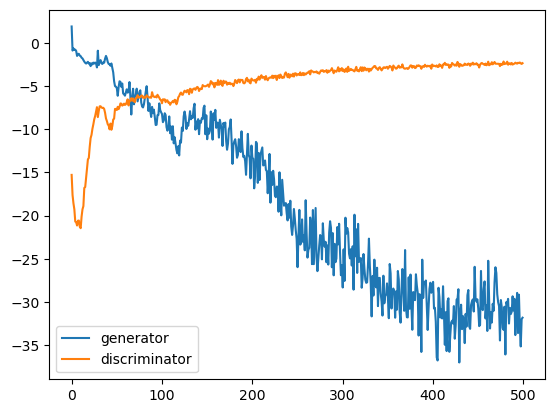

In [23]:
plt.figure()
plt.plot(loss_G, label='generator')
plt.plot(loss_D,label = 'discriminator')
plt.legend()
plt.show()